# 21_Dependency_Types_and_Basic_DI_Setup

---

## 1. Types of Dependencies in NestJS

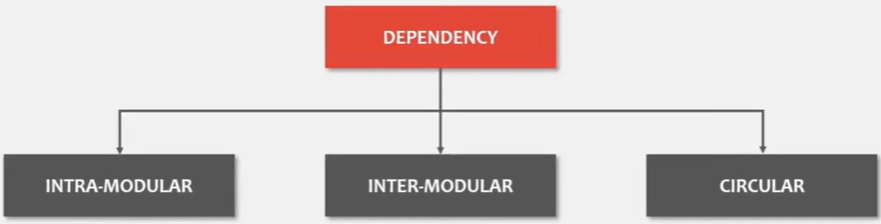

In NestJS, we commonly talk about three types of dependencies:

1. **Intramodular Dependency**
2. **Intermodular Dependency**
3. **Circular Dependency**

Let’s break each one down with simple explanations and mental diagrams.

---

### 1.1 Intramodular Dependency

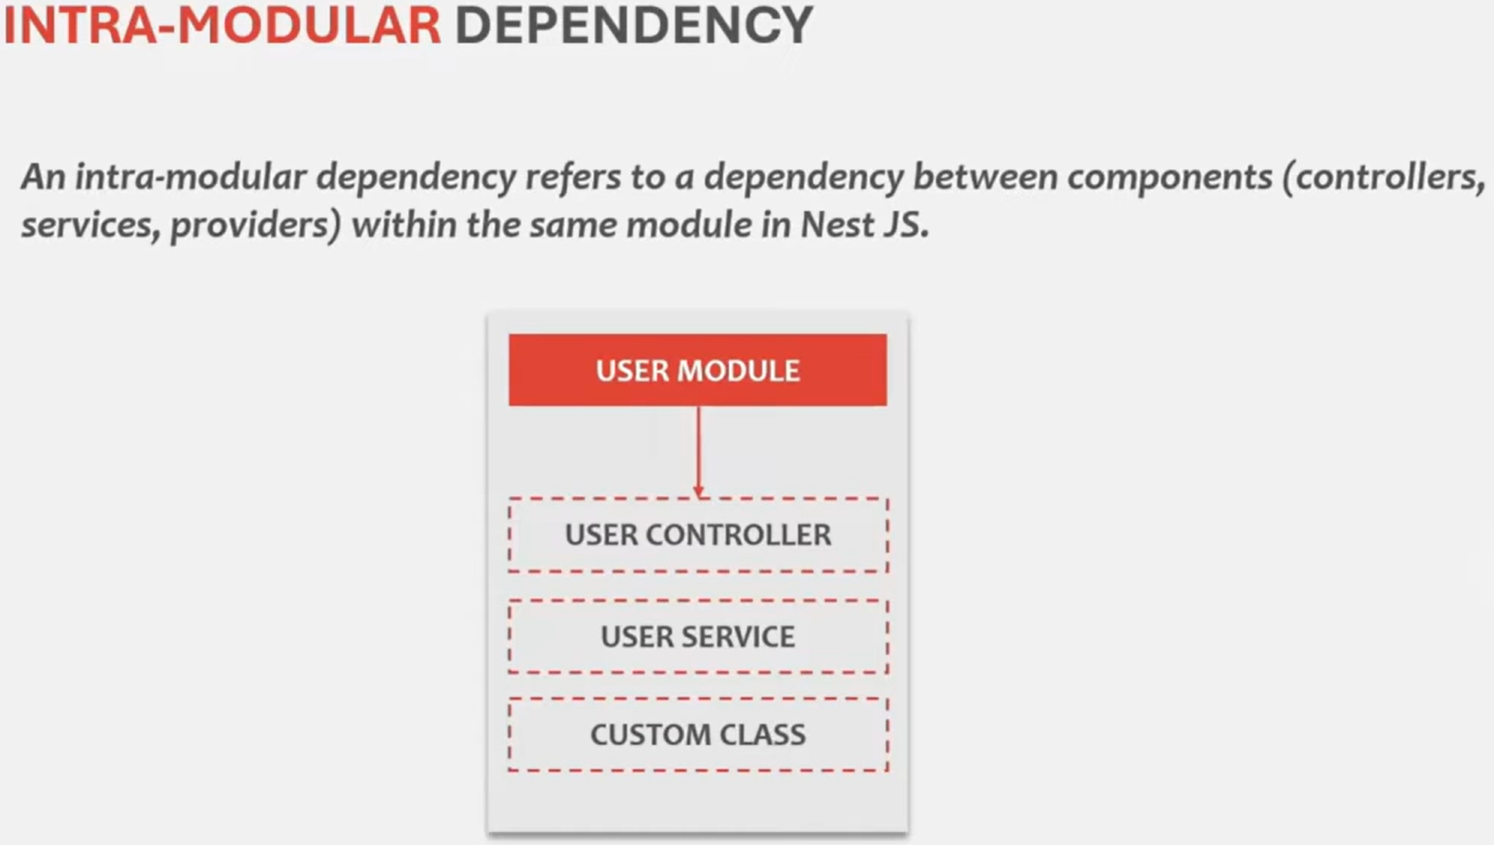

**Definition:**
A dependency between components **inside the same module**.

**Example scenario:**

* You have a `UsersModule`.
* Inside it, you have:

  * `UsersController`
  * `UsersService`
  * Maybe some helper/custom classes.
* `UsersController` needs to use `UsersService`.

So, we ask NestJS to **inject `UsersService` into `UsersController`**.

```ts
// users.module.ts
@Module({
  controllers: [UsersController],
  providers: [UsersService],
})
export class UsersModule {}

// users.controller.ts
@Controller('users')
export class UsersController {
  constructor(private readonly usersService: UsersService) {}
}

// users.service.ts
@Injectable()
export class UsersService {
  // business logic
}
```

Here:

* Both `UsersController` and `UsersService` are part of **`UsersModule`**.
* `UsersController` depends on `UsersService`.
* This is an **intramodular dependency**.

You’ve already seen this pattern in your earlier lectures when injecting `UsersService` into `UsersController`.

---

### 1.2 Intermodular Dependency


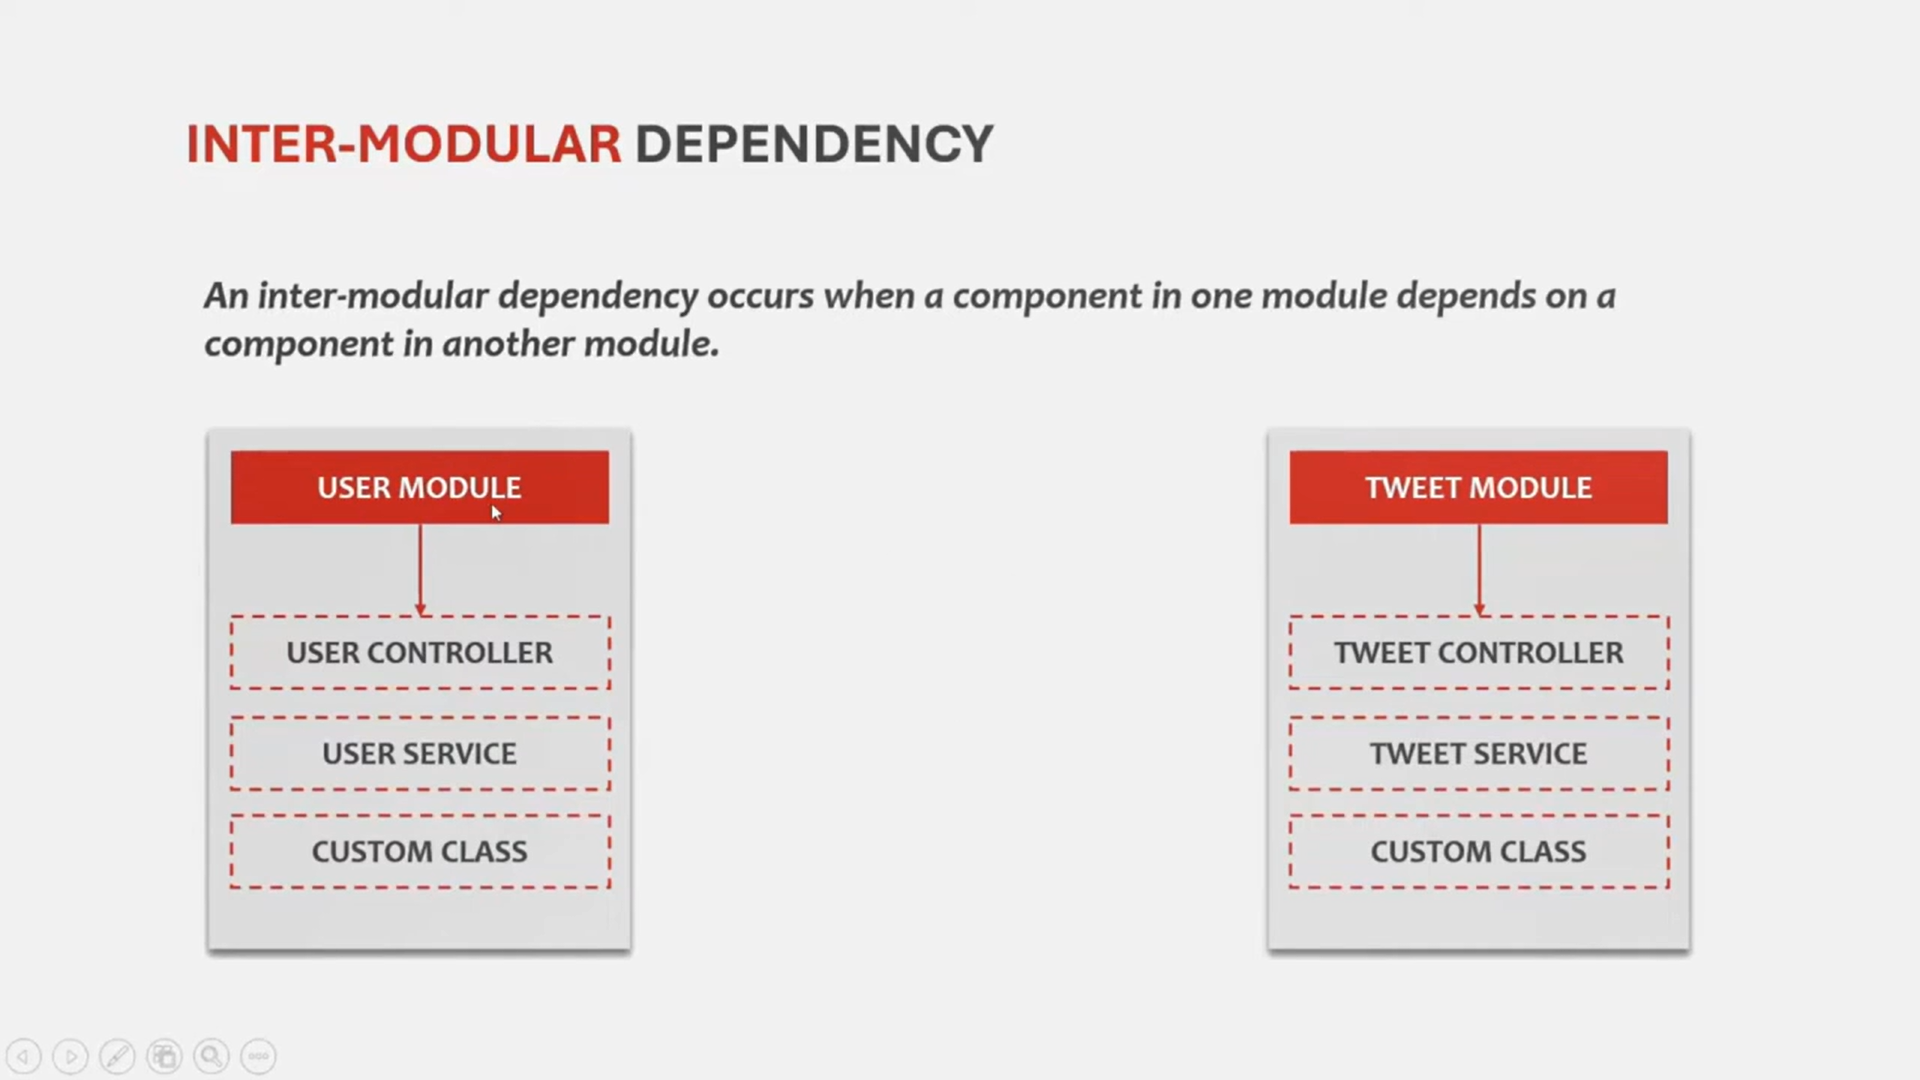


**Definition:**
A dependency where a component in **one module** depends on a component in **another module**.

**Example scenario:**

* You have two modules:

  * `UsersModule`
  * `TweetsModule`
* In `TweetsModule`, there is a `TweetsService`.
* In `UsersModule`, there is a `UsersService`.
* Now you want `TweetsService` to use `UsersService` (e.g. to fetch user details while creating a tweet).

Conceptually:

* `TweetsService` (in `TweetsModule`) → depends on → `UsersService` (in `UsersModule`).

High level idea (not full code):

* `UsersService` is **provided and exported** from `UsersModule`.
* `TweetsModule` **imports** `UsersModule`.
* `TweetsService` can now inject `UsersService`.

This cross-module relationship is called **intermodular dependency**.
You’ll usually handle this using the `imports` and `exports` arrays in your modules.

---

### 1.3 Circular Dependency


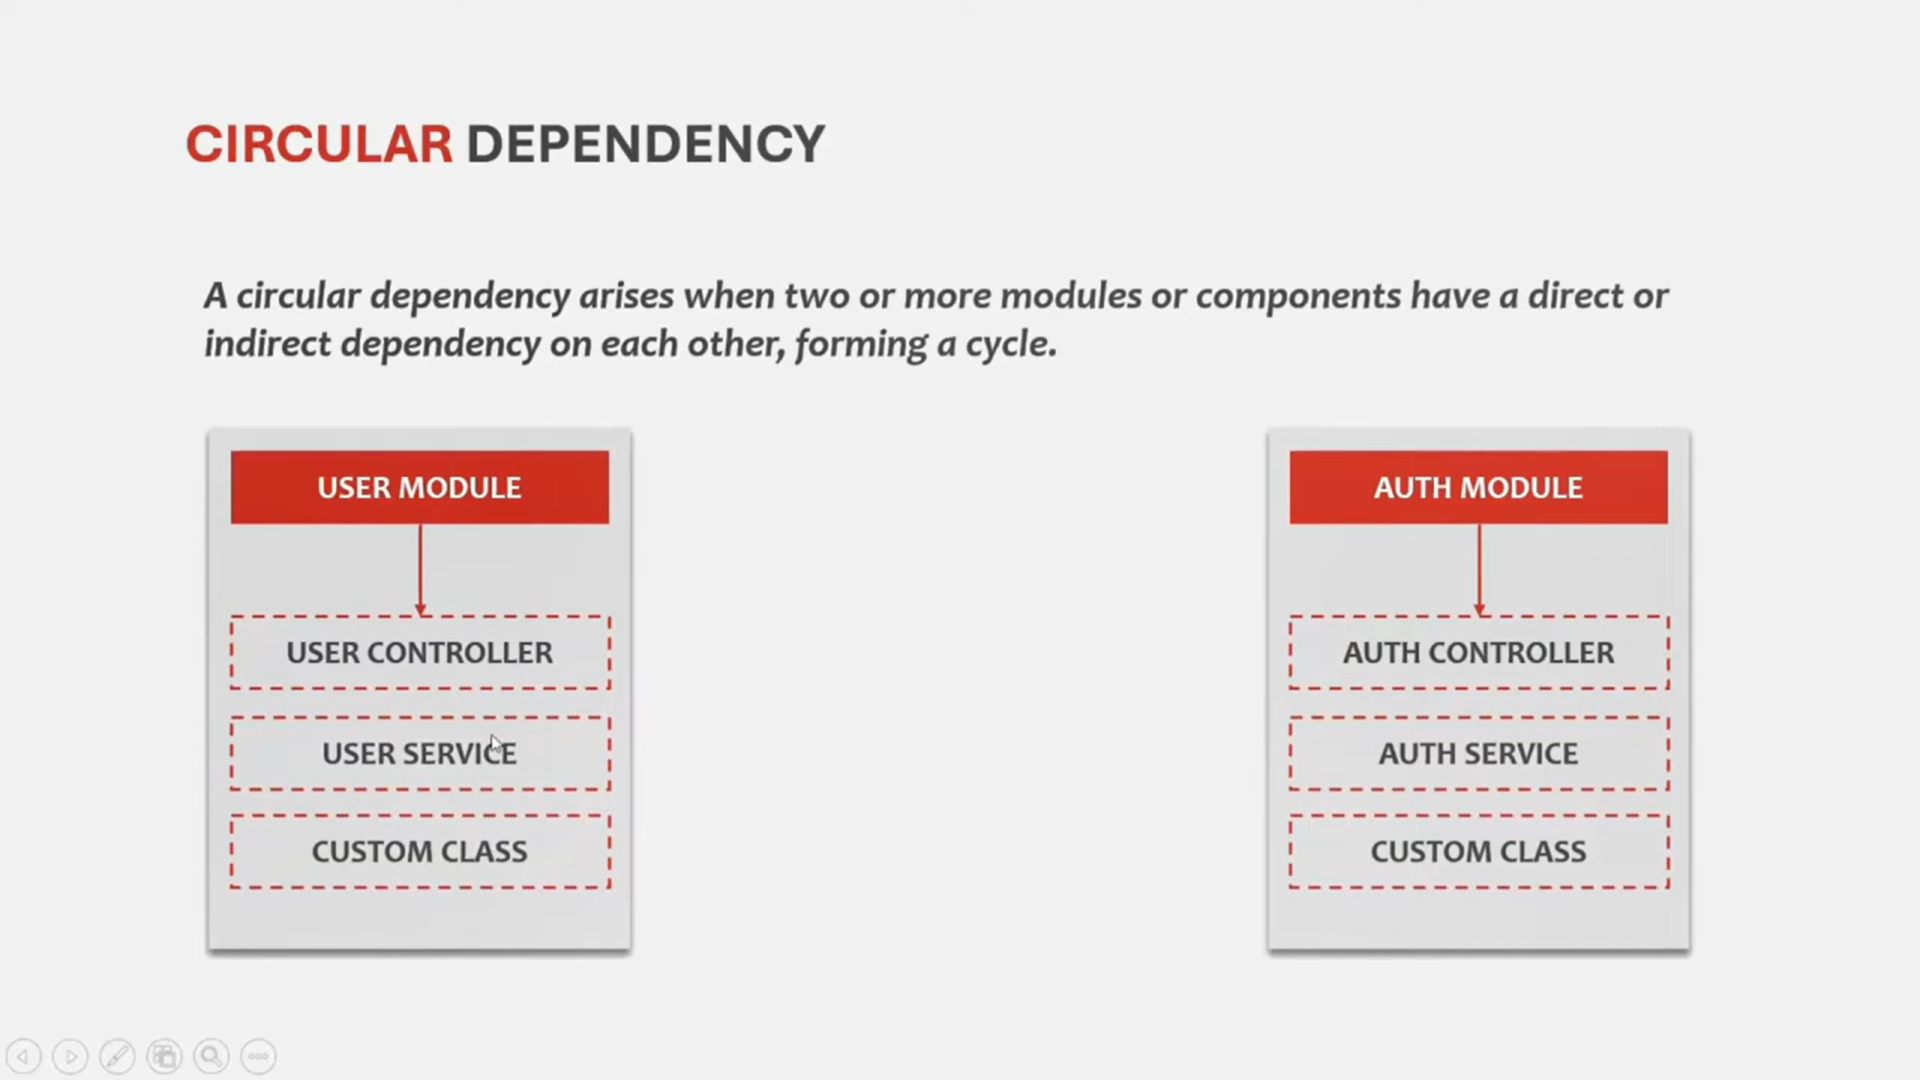


**Definition:**
A circular dependency happens when **two (or more) components depend on each other**, directly or indirectly, forming a **cycle**.

**Example scenario:**

* `AuthService` needs `UsersService` to authenticate users.
* `UsersService` also needs `AuthService` to, for example, verify current user, check permissions, etc.

So you end up with:

* `AuthService` → depends on → `UsersService`
* `UsersService` → depends on → `AuthService`

This is a **circular dependency**.

> 🔴 **Important:** Circular dependencies are usually a **code smell**.
> They can make the code harder to understand, harder to test, and can break DI resolution.

You should **avoid circular dependencies** as much as possible by:

* Splitting shared logic into a third service or module.
* Refactoring responsibilities so only one side depends on the other.

NestJS does provide tools like `forwardRef()` to handle circular dependencies when they’re truly unavoidable, and you’ll see examples of this later.

---

## 2. Setting Up Another Module: TweetsModule

To understand inter-module relationships and practice DI, we create another module: **`TweetsModule`**.

We assume you already have a `UsersModule`. Now we add:

* `TweetsModule`
* `TweetsController`
* `TweetsService`

### 2.1 Creating `TweetsModule` & `TweetsController`

In the project, we already have:

* `tweet.module.ts`
* `tweet.controller.ts`
* A test file `tweet.controller.spec.ts` (created by Nest CLI)

Since the spec file is not needed right now, we **delete** `tweet.controller.spec.ts` to keep the project clean.

After that, we focus on:

* `tweet.module.ts`
* `tweet.controller.ts`

---

### 2.2 Generating `TweetService` with Nest CLI

We use the **Nest CLI** to generate a service:

```bash
nest g service tweet
```

This command will:

1. Create `tweet.service.ts`.
2. Create `tweet.service.spec.ts` (test file) – you can delete it if not needed now.
3. **Automatically update** `tweet.module.ts` and add `TweetService` to the `providers` array.

After running the command:

#### `tweet.service.ts`

```ts
import { Injectable } from '@nestjs/common';

@Injectable()
export class TweetService {
  // business logic for tweets will go here
}
```

* `@Injectable()` tells NestJS that this class can participate in **dependency injection**.

#### `tweet.module.ts`

```ts
import { Module } from '@nestjs/common';
import { TweetController } from './tweet.controller';
import { TweetService } from './tweet.service';

@Module({
  controllers: [TweetController],
  providers: [TweetService],
})
export class TweetModule {}
```

* `TweetService` is now listed in `providers`, so NestJS knows how to create and inject it.

You can delete `tweet.service.spec.ts` for now if you’re not writing tests yet.

---

## 3. Injecting `TweetService` into `TweetController`

Now that `TweetService` is registered as a provider, we want to **use it inside `TweetController`**.

This is another example of **intramodular dependency**:

* Both `TweetController` and `TweetService` live in `TweetModule`.

### 3.1 Controller Injection Pattern

In `tweet.controller.ts`:

```ts
import { Controller } from '@nestjs/common';
import { TweetService } from './tweet.service';

@Controller('tweets')
export class TweetController {
  constructor(private readonly tweetService: TweetService) {}

  // Later: methods like @Get(), @Post(), etc., will use this.tweetService
}
```

Key points:

* The controller has a constructor parameter: `tweetService: TweetService`.
* Marked as `private readonly` so NestJS injects it and you can use `this.tweetService` in methods.
* The type of the parameter **must** be `TweetService` so NestJS knows what to inject.

Because:

* `TweetService` is decorated with `@Injectable()`.
* `TweetService` is listed in `providers` of `TweetModule`.

NestJS can successfully inject `TweetService` into `TweetController`.

This is standard NestJS DI in action.

---

## 4. Quick Recap

* **Intramodular dependency**:
  Components in the **same module** depend on each other

  * Example: `UsersController` → `UsersService`, `TweetController` → `TweetService`.

* **Intermodular dependency**:
  Components in **different modules** depend on each other

  * Example: `TweetsService` (in `TweetsModule`) needs `UsersService` (in `UsersModule`).

* **Circular dependency**:
  Two components depend on each other (e.g. `AuthService` ⇄ `UsersService`).

  * Usually a **code smell**, try to avoid.

* We used **Nest CLI** to generate `TweetService`, and NestJS automatically:

  * Created the service file.
  * Registered it in the module.

* We then injected `TweetService` into `TweetController` using the constructor pattern, demonstrating **intramodular DI** again.

This sets you up perfectly to move on to **inter-module DI** and **circular dependency handling** in the next parts of your NestJS notes.
